# Predicting uncertainty with (deep) neural networks

The idea is that a network that outputs a real-valued prediction can be (simply) modified to provide an estimate of the error on this prediction. Roughly speaking we do:

* Add an additional real-valued output to the network. The network now predicts two values: the output, $y$, and its error, $\sigma$

* Estimate the target value for the error, $\sigma$, from the difference between the target value of the output, $y$, and its predicted value, $\hat{y}$. We can use either: $\sigma^2 = (y-\hat{y})^2$ or $\sigma = \left| y-\hat{y}\right|$

* An easy way to do this at training time is with a customised loss function

### Imports 

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import torch.nn.functional as F

%matplotlib inline

### Generate some random data

In [82]:
# Generate some linearly related data
n_samples = 10000
x = np.random.random(n_samples)
eps = np.random.normal(scale=1.0, size=n_samples) * 0.4*np.sin(x*4*np.pi)
y = 2*x + 1 + eps

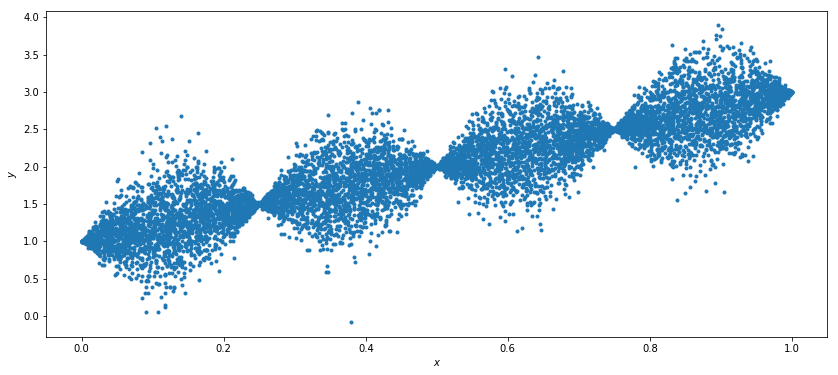

In [83]:
# Plot the data
plt.figure(figsize=(14,6))
plt.plot(x, y, '.')
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

In [84]:
# Add in column of dummy zeros to represent sigma 
sigma = np.zeros(10000)
y = np.stack([y, sigma], axis=1)

In [85]:
# Reshape x for PyTorch
x = x.reshape(10000, 1)

In [86]:
# Split into training and validation sets
n_validation = 500
x_val, x = x[:n_validation], x[n_validation:]
y_val, y = y[:n_validation], y[n_validation:]

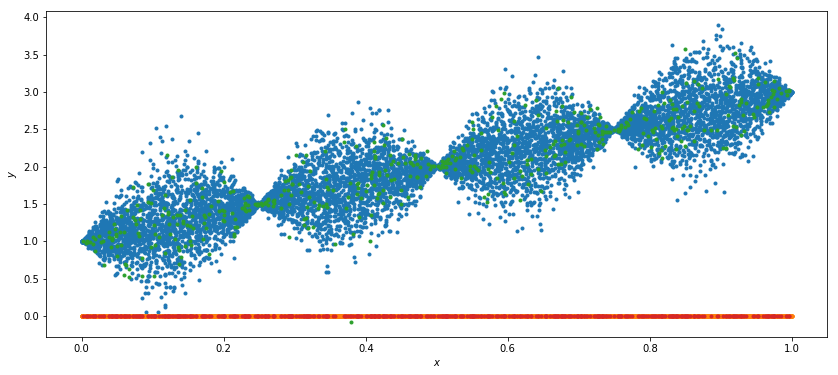

In [125]:
# Plot the data
plt.figure(figsize=(14,6))
plt.plot(x, y, '.')
plt.plot(x_val, y_val, '.')
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

In [87]:
# Convert x and y to PyTorch Variables on the GPU
dtype = torch.FloatTensor
x = Variable(torch.from_numpy(x).type(dtype))
y = Variable(torch.from_numpy(y).type(dtype), requires_grad=False)

In [88]:
# Check shape ok for PyTorch - x should be (n x 1), y (n x 2)
x.shape, y.shape

(torch.Size([9500, 1]), torch.Size([9500, 2]))

### Create a simple network 

In [9]:
# Create a simple two-layer network with one input (x) and two outputs (y, sigma)
n_inputs = 1
n_outputs = 2
n_hidden = 1000
model = torch.nn.Sequential(torch.nn.Linear(n_inputs, n_hidden),
                            torch.nn.ReLU(),
                            torch.nn.Linear(n_hidden, n_outputs)
                           )

In [10]:
# Adam optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Custom loss function
This is where the magic happens.

In [11]:
def custom_loss(input, target):
    
    # Estimate target value for sigma with abs(y_pred - y)
    #
    #    actual y     is target[:,0]
    # predicted y     is input[:,0]
    #    actual sigma is target[:,1]
    # predicted sigma is input[:,0]
    
    # Use 'requires_grad == False' to prevent PyTorch from trying to differentiate 'target'
    target[:,1] = Variable((input[:,0].data - target[:,0].data)**2, 
                           requires_grad=False)  
    # Return MSE loss 
    return F.mse_loss(input, target)

### Training loop 
We train this simple model with batch size equal to the whole dataset.

In [12]:
n_epochs = 10000
for i in range(n_epochs):
    
    # Calculate predicted y from x
    y_pred = model(x)
    
    # Calculate loss
    loss = custom_loss(y_pred, y)
    if i%100 == 0:
        print('epoch: {}, loss {}'.format(i, loss))

    # Backprop, first zeroing gradients
    optimizer.zero_grad()
    loss.backward()

    # Update parameters
    optimizer.step()

epoch: 0, loss 23.996227264404297
epoch: 100, loss 0.394298255443573
epoch: 200, loss 0.12094759196043015
epoch: 300, loss 0.07065676897764206
epoch: 400, loss 0.05660102516412735
epoch: 500, loss 0.05258280783891678
epoch: 600, loss 0.051586978137493134
epoch: 700, loss 0.05133027955889702
epoch: 800, loss 0.051227863878011703
epoch: 900, loss 0.05116209015250206
epoch: 1000, loss 0.051111605018377304
epoch: 1100, loss 0.051068566739559174
epoch: 1200, loss 0.05103043466806412
epoch: 1300, loss 0.050995808094739914
epoch: 1400, loss 0.05096367001533508
epoch: 1500, loss 0.05093303322792053
epoch: 1600, loss 0.050903644412755966
epoch: 1700, loss 0.05087568238377571
epoch: 1800, loss 0.050849515944719315
epoch: 1900, loss 0.0508248507976532
epoch: 2000, loss 0.0508003830909729
epoch: 2100, loss 0.05077492818236351
epoch: 2200, loss 0.050750311464071274
epoch: 2300, loss 0.05072696879506111
epoch: 2400, loss 0.05070488899946213
epoch: 2500, loss 0.050683945417404175
epoch: 2600, loss 0.

### Get predictions for validation set 

In [90]:
# Get predicted y and sigma for validation set
x_val_pytorch = Variable(torch.from_numpy(x_val).type(dtype)) 
pred = model(x_val_pytorch)
y_pred = pred[:,0].cpu().data
variance_pred = pred[:,1].cpu().data

### Plot results

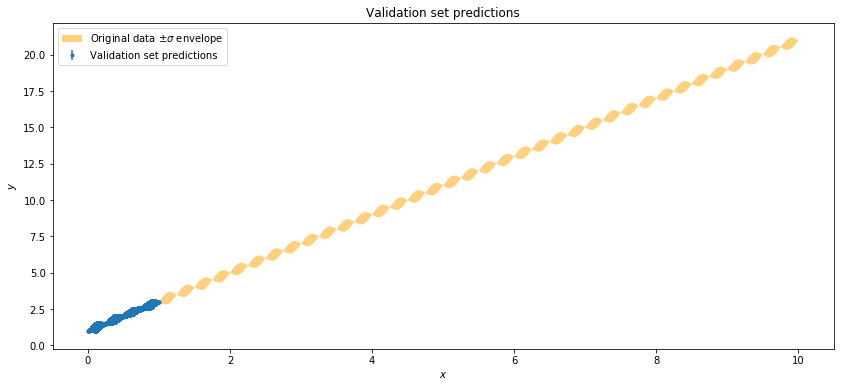

In [119]:
# Plot predictions and their errors
plt.figure(figsize=(14,6))
plt.errorbar(x_val, y_pred.numpy(), yerr=variance_pred.sqrt().numpy(), fmt='.');


# One standard-deviation envelope
xs = np.linspace(1.0, 10.0, 500)
err = 0.4*np.sin(xs*4*np.pi)
plt.fill_between(xs, 2*xs+1-err, 2*xs+1+err, facecolor='orange', alpha=0.5, edgecolor='none');
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.title('Validation set predictions');
plt.legend([r'Original data $\pm \sigma$ envelope','Validation set predictions'], loc='upper left', );

In [121]:
z_samples = 10000
z_x = np.random.random(z_samples)*10
z_x_eps = np.random.normal(scale=1.0, size=z_samples) * 0.4*np.sin(z_x*4*np.pi)
x_y = 2*z_x + 1 + z_x_eps
z_x = z_x.reshape(10000, 1)


z_pred = model( Variable(torch.from_numpy(z_x).type(dtype))  )
z_y_pred = z_pred[:,0].cpu().data
z_variance_pred = z_pred[:,1].cpu().data

In [133]:
z_y_pred.shape

torch.Size([10000])

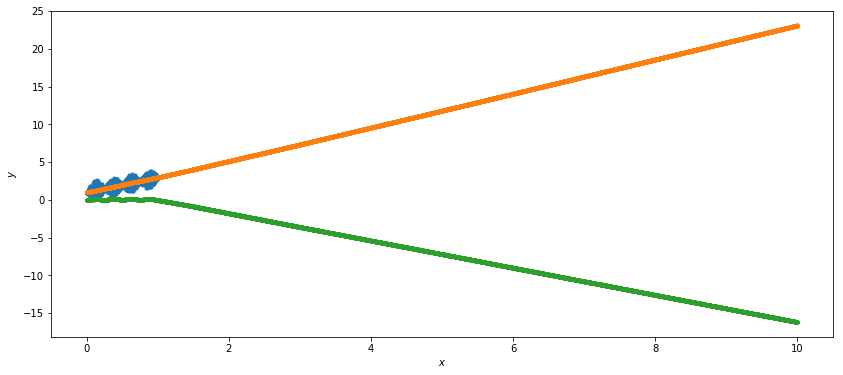

In [135]:
# Plot the data
plt.figure(figsize=(14,6))
plt.plot(x, y[:,0], '.')
plt.plot(z_x, z_y_pred, '.')
plt.plot(z_x, z_variance_pred, '.')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

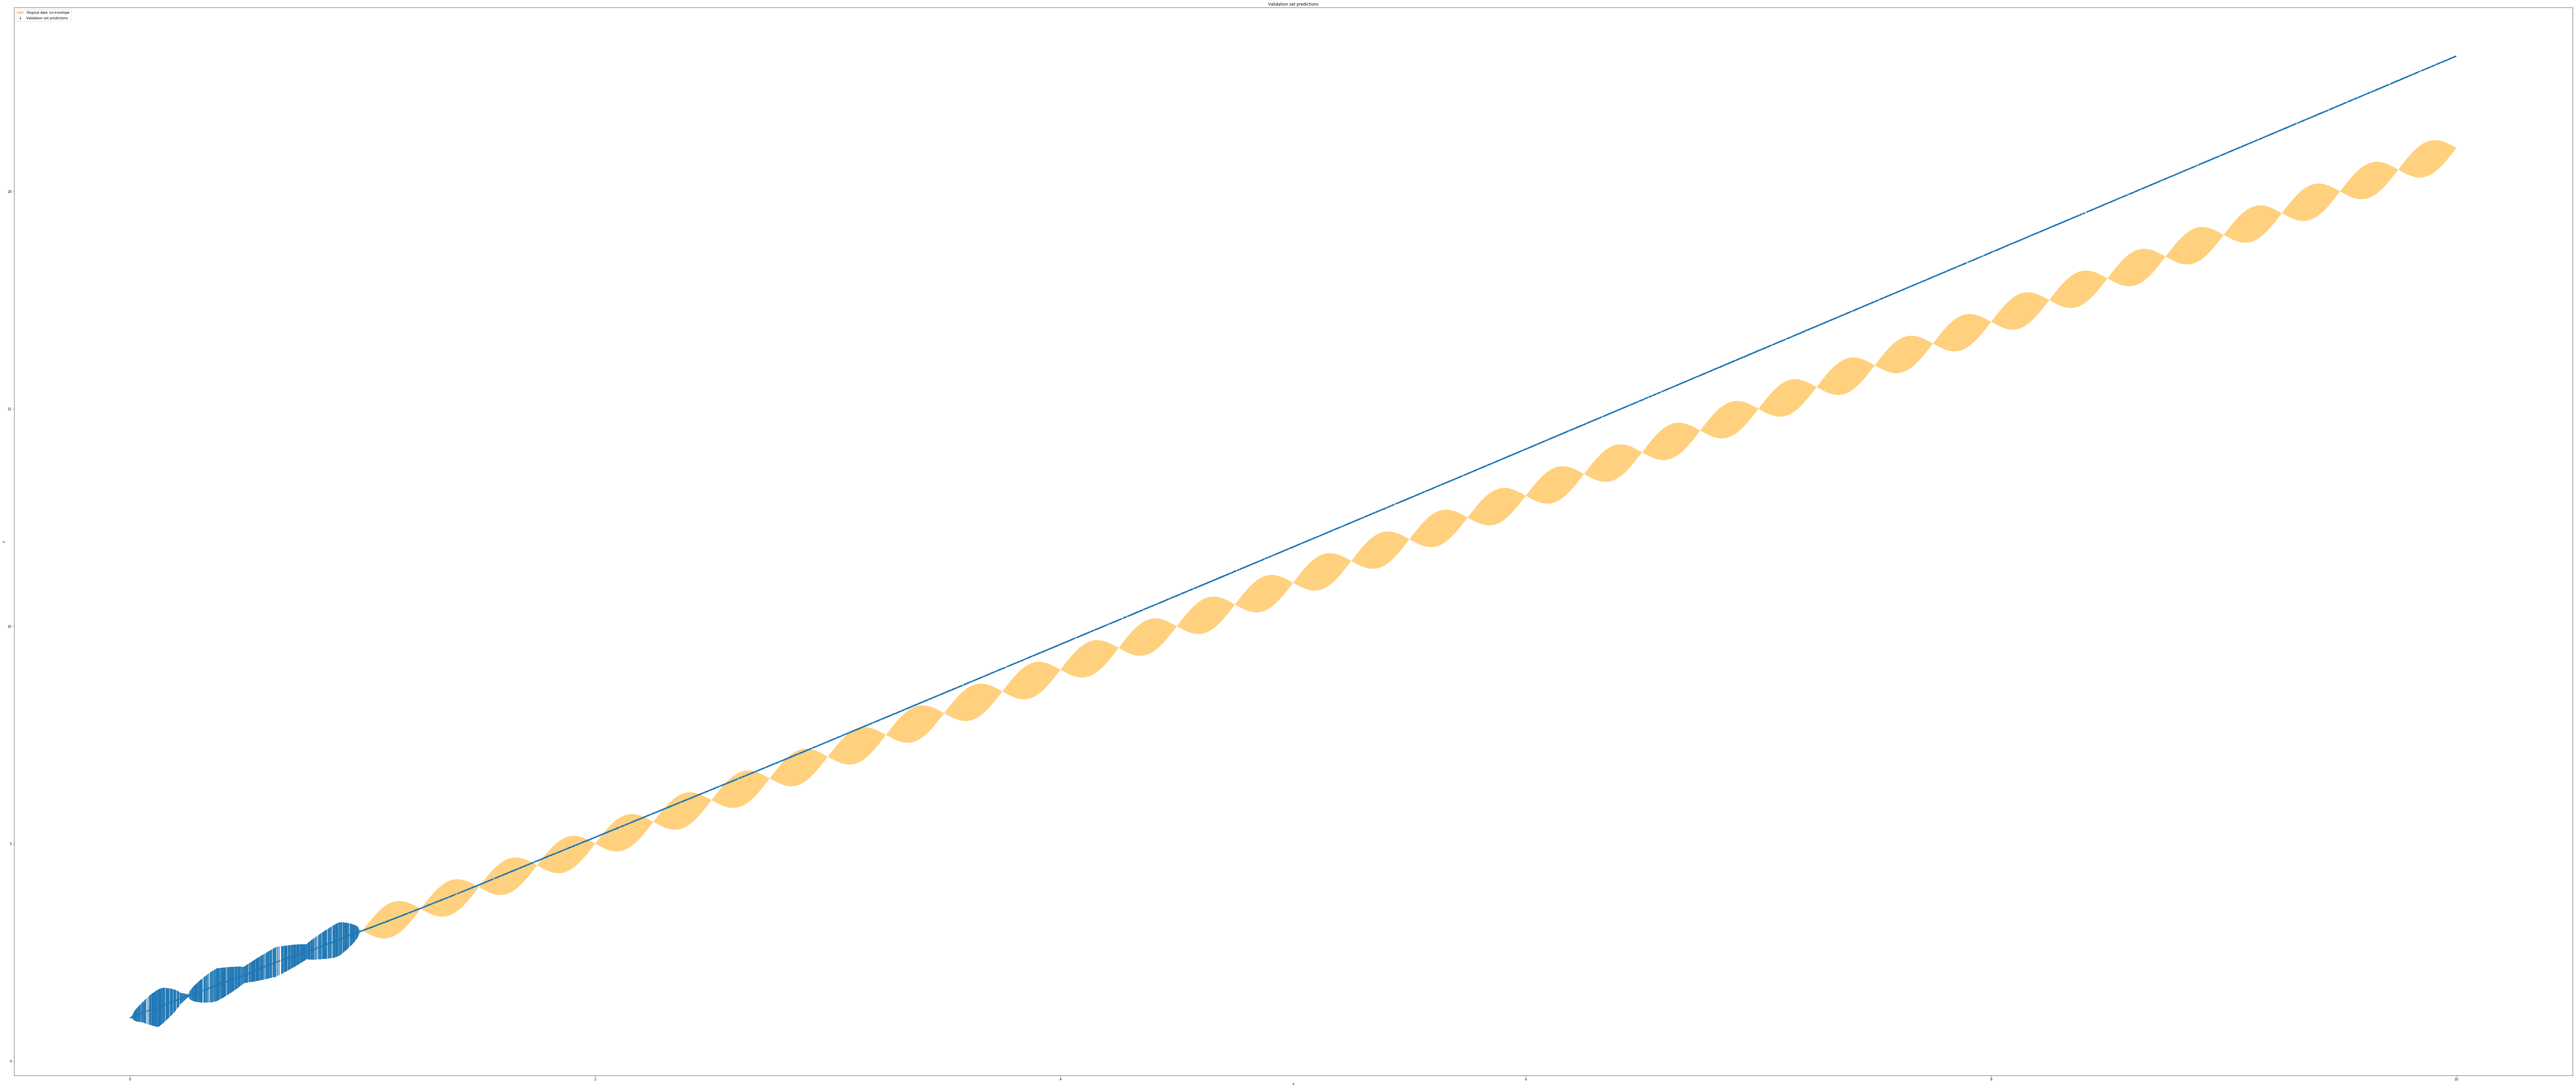

In [124]:
# Plot predictions and their errors
plt.figure(figsize=(140,60))
plt.errorbar(z_x, z_y_pred.numpy(), yerr=z_variance_pred.sqrt().numpy(), fmt='.')

# One standard-deviation envelope
xs = np.linspace(1.0, 10.0, 500)
err = 0.4*np.sin(xs*4*np.pi)
plt.fill_between(xs, 2*xs+1-err, 2*xs+1+err, facecolor='orange', alpha=0.5, edgecolor='none');
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.title('Validation set predictions');
plt.legend([r'Original data $\pm \sigma$ envelope','Validation set predictions'], loc='upper left', );